<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html Project2.do.txt  -->
<!-- dom:TITLE: Project 2 on Machine Learning, deadline November 10 (Midnight) -->

# Project 2 on Machine Learning, deadline November 10 (Midnight)
**[Data Analysis and Machine Learning FYS-STK3155/FYS4155](http://www.uio.no/studier/emner/matnat/fys/FYS3155/index-eng.html)**, University of Oslo, Norway

Date: **October 14, 2025**

## Deliverables

First, join a group in canvas with your group partners. Pick an avaliable group for Project 2 in the **People** page.

In canvas, deliver as a group and include:

* A PDF of your report which follows the guidelines covered below and in the week 39 exercises. Additional requirements include:

  * It should be around 5000 words, use the word counter in Overleaf for this. This often corresponds to 10-12 pages. References and appendices are excluded from the word count

  * It should include around 10-15 figures. You can include more figures in appendices and/or as supplemental material in your repository.

* A comment linking to your github repository (or folder in one of your github repositories) for this project. The repository must include

A PDF file of the report
  * A folder named Code, where you put python files for your functions and notebooks for reproducing your results. Remember to use a seed for generating random data and for train-test splits when generating final results.

  * A README file with the name of the group members

  * a short description of the project

  * a description of how to install the required packages to run your code from a requirements.txt file or similar (such as a plain text description) names and descriptions of the various notebooks in the Code folder and the results they produce

### Preamble: Note on writing reports, using reference material, AI and other tools

We want you to answer the three different projects by handing in
reports written like a standard scientific/technical report. The links
at
https://github.com/CompPhysics/MachineLearning/tree/master/doc/Projects
contain more information. There you can find examples of previous
reports, the projects themselves, how we grade reports etc. How to
write reports will also be discussed during the various lab
sessions. Please do ask us if you are in doubt.

When using codes and material from other sources, you should refer to
these in the bibliography of your report, indicating wherefrom you for
example got the code, whether this is from the lecture notes,
softwares like Scikit-Learn, TensorFlow, PyTorch or other
sources. These sources should always be cited correctly. How to cite
some of the libraries is often indicated from their corresponding
GitHub sites or websites, see for example how to cite Scikit-Learn at
https://scikit-learn.org/dev/about.html.

We enocurage you to use tools like ChatGPT or similar in writing the
report. If you use for example ChatGPT, please do cite it properly and
include (if possible) your questions and answers as an addition to the
report. This can be uploaded to for example your website,
GitHub/GitLab or similar as supplemental material.

If you would like to study other data sets, feel free to propose other
sets. What we have proposed here are mere suggestions from our
side. If you opt for another data set, consider using a set which has
been studied in the scientific literature. This makes it easier for
you to compare and analyze your results. Comparing with existing
results from the scientific literature is also an essential element of
the scientific discussion. The University of California at Irvine with
its Machine Learning repository at
https://archive.ics.uci.edu/ml/index.php is an excellent site to look
up for examples and inspiration. Kaggle.com is an equally interesting
site. Feel free to explore these sites.

## Classification and Regression, writing our own neural network code

The main aim of this project is to study both classification and
regression problems by developing our own 
feed-forward neural network (FFNN) code. The exercises from week 41 and 42 (see <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/exercisesweek41.html> and <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/exercisesweek42.html>) as well as the lecture material from the same weeks (see  <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week41.html> and <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week42.html>) should contain enough information for you to get started with writing your own code.

We will also reuse our codes on gradient descent methods from project 1.

The data sets that we propose here are (the default sets)

* Regression (fitting a continuous function). In this part you will need to bring back your results from project 1 and compare these with what you get from your Neural Network code to be developed here. The data sets could be

  * The simple one-dimensional function Runge function from project 1, that is $f(x) = \frac{1}{1+25x^2}$. We recommend using a simpler function when developing your neural network code for regression problems. Feel however free to discuss and study other functions, such as the two-dimensional Runge function $f(x,y)=\left[(10x - 5)^2 + (10y - 5)^2 + 1 \right]^{-1}$, or even more complicated two-dimensional functions (see the supplementary material of <https://www.nature.com/articles/s41467-025-61362-4> for an extensive list of two-dimensional functions). 

* Classification.

 * We will consider a multiclass classification problem given by the full MNIST data set. The full data set is at <https://www.kaggle.com/datasets/hojjatk/mnist-dataset>.

We will start with a regression problem and we will reuse our codes on gradient descent methods from project 1.

### Part a): Analytical warm-up

When using our gradient machinery from project 1, we will need the expressions for the cost/loss functions and their respective
gradients. The functions whose gradients we need are:
1. The mean-squared error (MSE) with and without the $L_1$ and $L_2$ norms (regression problems)

2. The binary cross entropy (aka log loss)  for binary classification problems with and without $L_1$ and $L_2$ norms

3. The multiclass cross entropy cost/loss function (aka Softmax cross entropy or just Softmax loss function)

Set up these three cost/loss functions and their respective derivatives and explain the various terms. In this project you will however only use the MSE and the Softmax  cross entropy.

We will test three activation functions for our neural network setup, these are the 
1. The Sigmoid (aka **logit**) function,

2. the RELU function and

3. the Leaky RELU function

Set up their expressions and their first derivatives.
You may consult the lecture notes (with codes and more) from week 42 at <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week42.html>.

### Reminder about the gradient machinery from project 1

In the setup of a neural network code you will need your gradient descent codes from
project 1.  For neural networks we will recommend using stochastic
gradient descent with either the RMSprop or the ADAM algorithms for
updating the learning rates. But you should feel free to try plain gradient descent as well.

We recommend reading chapter 8 on optimization from the textbook of
Goodfellow, Bengio and Courville at
<https://www.deeplearningbook.org/>. This chapter contains many
useful insights and discussions on the optimization part of machine
learning.  A useful reference on the back progagation algorithm is
Nielsen's book at <http://neuralnetworksanddeeplearning.com/>. 

You will find the Python [Seaborn
package](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
useful when plotting the results as function of the learning rate
$\eta$ and the hyper-parameter $\lambda$ .

### Part b): Writing your own Neural Network code

Your aim now, and this is the central part of this project, is to
write your own FFNN code implementing the back
propagation algorithm discussed in the lecture slides from week 41 at <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week41.html> and week 42 at <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week42.html>.

We will focus on a regression problem first, using the one-dimensional Runge function

$$
f(x) = \frac{1}{1+25x^2},
$$

from project 1.

Use only the mean-squared error as cost function (no regularization terms) and 
write an FFNN code for a regression problem with a flexible number of hidden
layers and nodes using only the Sigmoid function as activation function for
the hidden layers. Initialize the weights using a normal
distribution. How would you initialize the biases? And which
activation function would you select for the final output layer?
And how would you set up your design/feature matrix? Hint: does it have to represent a polynomial approximation as you did in project 1? 

Train your network and compare the results with those from your OLS
regression code from project 1 using the one-dimensional Runge
function.  When comparing your neural network code with the OLS
results from project 1, use the same data sets which gave you the best
MSE score. Moreover, use the polynomial order from project 1 that gave you the
best result.  Compare these results with your neural network with one
and two hidden layers using $50$ and $100$ hidden nodes, respectively.

Comment your results and give a critical discussion of the results
obtained with the OLS code from project 1 and your own neural network
code.  Make an analysis of the learning rates employed to find the
optimal MSE score. Test both stochastic gradient descent
with RMSprop and ADAM and plain gradient descent with different
learning rates.

You should, as you did in project 1, scale your data.

In [92]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import sys
import random
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from autograd import grad
import copy
from typing import Literal

# own functions
from ml_project1.functions import *

from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{sansmathfonts}'
rcParams.update({
    "font.size": 9,       
    "axes.labelsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    'axes.titlesize':10
})
def saveplot(plotname):
    return plt.savefig("../LaTeX/images/{}.pdf".format(str(plotname)))
cw = 8.325/2.54
tw = 17/2.54

In [3]:
def Runge(x, noise=True, noisescale=1):
    """Computes Runge function with or without normally distributed noise."""
    if not isinstance(noise, bool):
        raise TypeError(f"`noise` must be boolean (True or False) and not {type(noise)}")

    y = 1 / (1 + 25 * x**2)

    if noise:
        y += np.random.normal(loc=0, scale=noisescale, size=x.shape)

    return y

In [36]:
import autograd.numpy as np  # We need to use this numpy wrapper to make automatic differentiation work later
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


# Defining some activation functions

def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)


def leaky_ReLU(z):
    return np.where(z > 0, z, 0.01 * z)

def leaky_ReLU_der(z):
    return np.where(z > 0, 1, 0.01)


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    # -(1 + np.exp(-z))^(-2) * (-np.exp(-x))
    return np.exp(-z) / (1 + np.exp(-z))**2


def mse(predict, targets, weights=None, regression_method="OLS", lbda=0.1):
    residuals = predict - targets

    if regression_method == 'OLS':
        return np.mean(residuals**2)
    
    elif regression_method == 'Ridge':
        return np.mean(residuals**2) + lbda * np.sum(weights**2)
    
    elif regression_method == 'Lasso':
        return np.mean(residuals**2) + lbda * np.sum(np.abs(weights))
    
    else:
        raise ValueError(f"`regression_method` must be 'OLS', 'Ridge' or 'Lasso', not {regression_method}")


def mse_der(predict, targets):
    """
    Computes the gradient of MSE loss w.r.t predictions (and includes L1/L2 regularization on weights).
    """
    n = targets.shape[0]
    residuals = predict - targets

    grad = (2 / n) * residuals

    return grad


In [57]:
activation_functions_dic = {
    'ReLU'       : (ReLU, ReLU_der),
    'leaky_ReLU' : (leaky_ReLU, leaky_ReLU_der),
    'sigmoid'    : (sigmoid, sigmoid_der),
    }

cost_functions_dic = {
    'MSE'           : (mse, mse_der),
    #'cross_entropy' : (cross_entropy, cross_entropy_der)
    }


In [59]:
def set_activations(
        functions_dic  : dict,
        functions_names_list : list):
    
    activation_funcs = list()
    activation_funcs_ders = list()

    for func_name in functions_names_list:
        for key in functions_dic.keys():
            if func_name == key:
                activation_funcs.append(functions_dic[key][0])
                activation_funcs_ders.append(functions_dic[key][1])

    return activation_funcs, activation_funcs_ders

In [5]:
class Scheduler:
    """
    Abstract class for Schedulers
    """

    def __init__(self, eta=1e-3):
        self.eta = eta

    # should be overwritten
    def update_change(self, gradient):
        raise NotImplementedError

    # overwritten if needed
    def reset(self):
        pass

class Constant(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)

    def update_change(self, gradient):
        return self.eta * gradient
    
    def reset(self):
        pass

class RMSProp(Scheduler):
    def __init__(self, eta, beta=0.99):
        super().__init__(eta)
        self.beta = beta
        self.second = 0.0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero
        self.second = self.beta * self.second + (1 - self.beta) * gradient * gradient
        return self.eta * gradient / (np.sqrt(self.second + delta))

    def reset(self):
        self.second = 0.0


class Adam(Scheduler):
    def __init__(self, eta, beta1=0.9, beta2=0.999):
        super().__init__(eta)
        self.beta1 = beta1
        self.beta2 = beta2
        self.moment = 0
        self.second = 0
        self.n_epochs = 1

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        self.moment = self.beta1 * self.moment + (1 - self.beta1) * gradient
        self.second = self.beta2 * self.second + (1 - self.beta2) * gradient * gradient

        moment_corrected = self.moment / (1 - self.beta1**self.n_epochs)
        second_corrected = self.second / (1 - self.beta2**self.n_epochs)

        return self.eta * moment_corrected / (np.sqrt(second_corrected + delta))

    def reset(self):
        self.n_epochs += 1
        self.moment = 0
        self.second = 0

In [ ]:
class NeuralNetwork:
    """
    Creates Neural Network object, adapted to batch inputs of shape \
    (< number of samples >, < number of features >). 
    It supports:
    - layers creation
    - simple Feed Forward algorithm
    - cost function definition
    - Feedforward with variables saving
    - Backpropagation
    - training
    - layers reset

    """

    def __init__(
        self,
        network_input_size,
        layer_output_sizes,
        activation_types : list,
        seed=42,
        cost_type="MSE",
        regression_method="OLS",
        lbda1=0,
        lbda2=0
    ):
        self.seed = seed
        self.network_input_size = network_input_size
        self.layer_output_sizes = layer_output_sizes
        self.activation_types = activation_types
        self.activation_funcs, self.activation_ders = set_activations(activation_functions_dic, self.activation_types)
        self.cost_type = cost_type
        self.regression_method = regression_method
        self.lbda1 = lbda1
        self.lbda2 = lbda2

        self.weights_biases = list()
        self.weights_biases_grads = list()
        self.layer_inputs = list()
        self.Zs = list()
        self.scheduler = None
        self.weights = list()
        self.schedulers_weight = list()
        self.schedulers_bias = list()


    def _create_layers(self):

        # ChatGPT: clear before creating new (W,b)
        self.weights_biases.clear()

        i_size = self.network_input_size

        for layer_output_size in self.layer_output_sizes:
            np.random.seed(self.seed)

            W = np.random.randn(i_size, layer_output_size)
            b = np.zeros((1, layer_output_size))
            self.weights_biases.append((W, b))

            i_size = layer_output_size

        self.weights_biases_grads = [() for _ in self.weights_biases]    
        return self.weights_biases
    

    def _predict(self, inputs): 

        if self.weights_biases is None:
            raise ValueError("`self.layers` is still None (empty tuple). You must run `_create_layers()` "\
                             "before performing Feed Forward or Back Propagation.")

        if np.shape(inputs)[1] == self.network_input_size: 
            A = inputs
        else:
            raise ValueError(f"Second dimension of inputs must match `network_input_size` (= number of features). "\
                             f"Inputs matrix has shape {inputs.shape}, but it should be {inputs.shape[0], self.network_input_size}. \n"\
                             "Either change your inputs matrix or `network_input_size`")
        
        for (W, b), activation_func in zip(self.weights_biases, self.activation_funcs):
            Z = A @ W + b
            A = activation_func(Z)

        return A


    def cost(self, predict, targets):
        if self.cost_type == "MSE":
            return np.mean((predict - targets) ** 2)
        else:
            raise ValueError(f"Cost type '{self.cost_type}' not defined. Can be 'MSE'.")
        
    
    def cost_der(self, predict, targets):
        if self.cost_type == "MSE":
            return 2 * (predict - targets) / targets.shape[0]
        else:
            raise ValueError(f"Cost type '{self.cost_type}' not defined. Can be 'MSE'.")


    def _feedforward(self, inputs):

        if self.weights_biases is None:
            raise ValueError("`self.layers` is still None (empty tuple). You must call `_create_layers()` "\
                             "before performing Feed Forward or Back Propagation.")

        if np.shape(inputs)[1] == self.network_input_size: 
            A = inputs
        else:
            raise ValueError(f"Second dimension of inputs must match `network_input_size` (= number of features). "\
                             f"Inputs matrix has shape {inputs.shape}, but it should be {inputs.shape[0], self.network_input_size}. \n"\
                             "Either change your inputs matrix or `network_input_size`")
        
        self.layer_inputs = []
        self.Zs = []

        for (W, b), activation_func in zip(self.weights_biases, self.activation_funcs):
            
            self.layer_inputs.append(A)
            Z = A @ W + b
            A = activation_func(Z)
            self.Zs.append(Z)

        return self.layer_inputs, self.Zs, A
    

    def _backpropagate(self, inputs, targets):
        
        if self.weights_biases is not None:
            layer_inputs, zs, predict = self._feedforward(inputs)
        else:
            raise ValueError("`self.layers` is still None (empty tuple). You must call `_create_layers()` "\
                             "before performing Feed Forward or Back Propagation.")

        # We loop over the layers, from the last to the first
        for i in reversed(range(len(self.weights_biases))):
            layer_input, z, activation_der = layer_inputs[i], zs[i], self.activation_ders[i]

            if i == len(self.weights_biases) - 1:
                # For last layer we use cost derivative as dC_da(L) can be computed directly
                dC_da = self.cost_der(predict, targets)
                pass
            else:
                # For other layers we build on previous z derivative, as dC_da(i) = dC_dz(i+1) * dz(i+1)_da(i)
                (W, b) = self.weights_biases[i + 1]
                dC_da = delta @ W.T

            delta = dC_da * activation_der(z)
            grad_weigths = layer_input.T @ delta
            grad_biases = np.sum(delta, axis=0, keepdims=True) / inputs.shape[0]

            if self.lbda1 != 0:
                grad_weigths += (self.lbda1 / inputs.shape[0]) * np.sign(self.weights_biases[i][0])
            if self.lbda2 != 0:
                grad_weigths += (2 * self.lbda2 / inputs.shape[0]) * self.weights_biases[i][0]
            
            self.weights_biases_grads[i] = (grad_weigths, grad_biases)
            
        return self.weights_biases_grads
    

    def _define_scheduler(self, 
                          type="Constant", 
                          eta=1e-3, 
                          beta=0.99, 
                          beta1=0.9, 
                          beta2=0.999):
        
        if type == "Constant":
            self.scheduler = Constant(eta)
        elif type == "RMSProp":
            self.scheduler = RMSProp(eta, beta=beta)
        elif type == "Adam":
            self.scheduler = Adam(eta, beta1=beta1, beta2=beta2)
        else:
            raise ValueError(f"Scheduler type '{type}' not defined. Can be 'Constant', 'RMSProp' or 'Adam'.")
        
        # this is a ChatGPT fix
        self.schedulers_weight = [copy.deepcopy(self.scheduler) for _ in self.weights_biases]
        self.schedulers_bias = [copy.deepcopy(self.scheduler) for _ in self.weights_biases]
        
        return self.scheduler


    def _update_weights(self):

        if len(self.weights_biases) == 0:
            raise ValueError(f"`self.weights_biases` is None. You must call `_create_layers()` before updating the weigths.") 
        
        if self.scheduler == None:
            raise ValueError(f"`self.scheduler` is None. You must call `_define_scheduler()` before updating the weigths.")
        
        if self.weights_biases_grads == None:
            raise ValueError(f"`self.weigths_biases_grad` is None. You must call `_backpropagate()` before updating the weigths.")
        
        for i, (W, b) in enumerate(self.weights_biases):
                dW, db = self.weights_biases_grads[i]
                W -= self.schedulers_weight[i].update_change(dW)
                b -= self.schedulers_bias[i].update_change(db)
                self.weights_biases[i] = (W, b)

    
    def _train(self,
              inputs,
              targets,
              n_epochs:  int=250,
              n_batches: int=20,
              ):
                                
        batch_size = inputs.shape[0] // n_batches

        for epoch in range(n_epochs):
            for i in range(n_batches):
                # allows for minibatch gradient descent
                if i == n_batches - 1:
                    # If the for loop has reached the last batch, take all thats left
                    inputs_batch = inputs[i * batch_size :, :]
                    targets_batch = targets[i * batch_size :, :]
                else:
                    inputs_batch = inputs[i * batch_size : (i + 1) * batch_size, :]
                    targets_batch = targets[i * batch_size : (i + 1) * batch_size, :]

                self._feedforward(inputs_batch)
                self._backpropagate(inputs_batch, targets_batch)
                self._update_weights()

                # reset schedulers for each epoch (some schedulers pass in this call)
            for scheduler in self.schedulers_weight:
                scheduler.reset()

            for scheduler in self.schedulers_bias:
                scheduler.reset()

    
    def _reset_weights(self):
        self.weights_biases.clear()
        self.weights_biases_grads.clear()
        self.layer_inputs.clear()
        self.Zs.clear()
        self.schedulers_weight.clear()
        self.schedulers_bias.clear()
        self._create_layers()

        if self.scheduler is not None:
            self.schedulers_weight = [copy.deepcopy(self.scheduler) for _ in self.weights_biases]
            self.schedulers_bias = [copy.deepcopy(self.scheduler) for _ in self.weights_biases]

In [67]:
x = np.linspace(-1, 1, 100).reshape(-1, 1)
y = Runge(x, noise=False)
print(x.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x = scaler.transform(x)

(100, 1)


0.0005334350853070295
0.9918054542473842


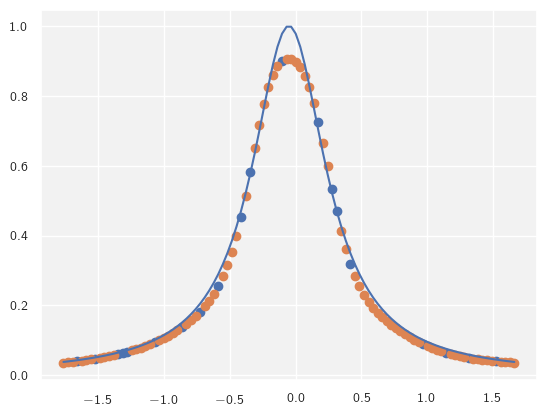

In [68]:
nn._create_layers()
nn._define_scheduler('Adam', eta=1e-4)
nn._train(x_train, y_train, 500)

predict_test = nn._predict(x_test)
predict_train = nn._predict(x_train)

plt.plot(x, y)
plt.scatter(x_test, predict_test)
plt.scatter(x_train, predict_train)

print(mse(predict_test, y_test))
print(r2_score(predict_test, y_test))

In [72]:
etas_range = [1e-2, 0.5e-2, 1e-3, 0.5e-3, 1e-4, 0.5e-4, 1e-5]
epochs_range = [100, 250, 500, 1000, 2500, 5000]
schedulers_types = ['Constant', 'RMSProp', 'Adam']

mse_matrices = list()
r2_matrices = list()

for scheduler in schedulers_types:
    mse_matrix = np.zeros((len(etas_range), len(epochs_range)))
    r2_matrix = np.zeros((len(etas_range), len(epochs_range)))

    for i, eta in enumerate(etas_range):
        for j, epochs in enumerate(epochs_range):
            nn._reset_weights()
            nn._define_scheduler(scheduler, eta=eta)
            nn._train(x_train, y_train, epochs)
            predict = nn._predict(x_test)
            mse_val = mse(predict, y_test)
            r2_val = r2_score(predict, y_test)

            mse_matrix[i, j] = mse_val
            r2_matrix[i, j] = r2_val
            print("Scheduler: {}: eta = {}, epochs = {} => MSE = {}, R2 = {}".format(scheduler, eta, epochs, mse_val, r2_val))
        
    mse_matrices.append(mse_matrix.copy())
    r2_matrices.append(r2_matrix.copy())

Scheduler: Constant: eta = 0.01, epochs = 100 => MSE = 0.02170422805349303, R2 = 0.43735481294942236
Scheduler: Constant: eta = 0.01, epochs = 250 => MSE = 0.009084093891431418, R2 = 0.8454472878448898
Scheduler: Constant: eta = 0.01, epochs = 500 => MSE = 0.004971793094890621, R2 = 0.9293078062946234
Scheduler: Constant: eta = 0.01, epochs = 1000 => MSE = 0.0035814429517212034, R2 = 0.9511811792541859
Scheduler: Constant: eta = 0.01, epochs = 2500 => MSE = 0.0023604971237695793, R2 = 0.9687666051348832
Scheduler: Constant: eta = 0.01, epochs = 5000 => MSE = 0.0016779280186620595, R2 = 0.9780993142258445
Scheduler: Constant: eta = 0.005, epochs = 100 => MSE = 0.03541255772955758, R2 = -0.5297532603974364
Scheduler: Constant: eta = 0.005, epochs = 250 => MSE = 0.0180475837084391, R2 = 0.5803591658553695
Scheduler: Constant: eta = 0.005, epochs = 500 => MSE = 0.009170329513986218, R2 = 0.8423542636992448
Scheduler: Constant: eta = 0.005, epochs = 1000 => MSE = 0.005017904730659916, R2 = 

In [ ]:
Scheduler: Constant: eta = 0.01, epochs = 100 => MSE = 0.02170422805349303, R2 = 0.43735481294942236
Scheduler: Constant: eta = 0.01, epochs = 250 => MSE = 0.009084093891431418, R2 = 0.8454472878448898
Scheduler: Constant: eta = 0.01, epochs = 500 => MSE = 0.004971793094890621, R2 = 0.9293078062946234
Scheduler: Constant: eta = 0.01, epochs = 1000 => MSE = 0.0035814429517212034, R2 = 0.9511811792541859
Scheduler: Constant: eta = 0.01, epochs = 2500 => MSE = 0.0023604971237695793, R2 = 0.9687666051348832
Scheduler: Constant: eta = 0.01, epochs = 5000 => MSE = 0.0016779280186620595, R2 = 0.9780993142258445
Scheduler: Constant: eta = 0.005, epochs = 100 => MSE = 0.03541255772955758, R2 = -0.5297532603974364
Scheduler: Constant: eta = 0.005, epochs = 250 => MSE = 0.0180475837084391, R2 = 0.5803591658553695
Scheduler: Constant: eta = 0.005, epochs = 500 => MSE = 0.009170329513986218, R2 = 0.8423542636992448
Scheduler: Constant: eta = 0.005, epochs = 1000 => MSE = 0.005017904730659916, R2 = 0.9282570854908535
Scheduler: Constant: eta = 0.005, epochs = 2500 => MSE = 0.0032758551383136486, R2 = 0.9555961609041473
Scheduler: Constant: eta = 0.005, epochs = 5000 => MSE = 0.00237627352081131, R2 = 0.9685036028992529
Scheduler: Constant: eta = 0.001, epochs = 100 => MSE = 0.06752520485602297, R2 = -10.043434196502112
Scheduler: Constant: eta = 0.001, epochs = 250 => MSE = 0.050299199491913284, R2 = -3.200622974093074
Scheduler: Constant: eta = 0.001, epochs = 500 => MSE = 0.03548435986845463, R2 = -0.5541837489354948
Scheduler: Constant: eta = 0.001, epochs = 1000 => MSE = 0.021852618477271282, R2 = 0.4182993735885999
Scheduler: Constant: eta = 0.001, epochs = 2500 => MSE = 0.009247108561602133, R2 = 0.839710080043929
Scheduler: Constant: eta = 0.001, epochs = 5000 => MSE = 0.005059406468754098, R2 = 0.9273425093825517
Scheduler: Constant: eta = 0.0005, epochs = 100 => MSE = 0.08907227846219158, R2 = -7.531716246686473
Scheduler: Constant: eta = 0.0005, epochs = 250 => MSE = 0.06333534673972896, R2 = -8.69735870745411
Scheduler: Constant: eta = 0.0005, epochs = 500 => MSE = 0.05030811525177746, R2 = -3.2089888341965587
Scheduler: Constant: eta = 0.0005, epochs = 1000 => MSE = 0.03549487951409917, R2 = -0.5572999654387023
Scheduler: Constant: eta = 0.0005, epochs = 2500 => MSE = 0.01813431740305277, R2 = 0.5730717147981887
Scheduler: Constant: eta = 0.0005, epochs = 5000 => MSE = 0.009257172670557128, R2 = 0.8393693792720924
Scheduler: Constant: eta = 0.0001, epochs = 100 => MSE = 0.12592159302253783, R2 = -5.486395692029648
Scheduler: Constant: eta = 0.0001, epochs = 250 => MSE = 0.1123110225093427, R2 = -6.546739168174756
Scheduler: Constant: eta = 0.0001, epochs = 500 => MSE = 0.08906728176199538, R2 = -7.541221441985559
Scheduler: Constant: eta = 0.0001, epochs = 1000 => MSE = 0.06753022097952185, R2 = -10.07905562578688
Scheduler: Constant: eta = 0.0001, epochs = 2500 => MSE = 0.050315482578507875, R2 = -3.2156702766950973
Scheduler: Constant: eta = 0.0001, epochs = 5000 => MSE = 0.035503527064267404, R2 = -0.5598012732884823
Scheduler: Constant: eta = 5e-05, epochs = 100 => MSE = 0.1307161445372242, R2 = -4.852606441057332
Scheduler: Constant: eta = 5e-05, epochs = 250 => MSE = 0.12366526153655093, R2 = -5.7460209183989885
Scheduler: Constant: eta = 5e-05, epochs = 500 => MSE = 0.11230997263159759, R2 = -6.547035049566405
Scheduler: Constant: eta = 5e-05, epochs = 1000 => MSE = 0.08906665414363832, R2 = -7.542395904409586
Scheduler: Constant: eta = 5e-05, epochs = 2500 => MSE = 0.06333970920133147, R2 = -8.713370268000393
Scheduler: Constant: eta = 5e-05, epochs = 5000 => MSE = 0.0503164178133366, R2 = -3.2165046782348794
Scheduler: Constant: eta = 1e-05, epochs = 100 => MSE = 0.13521096512577185, R2 = -4.247049540717106
Scheduler: Constant: eta = 1e-05, epochs = 250 => MSE = 0.1334197778505363, R2 = -4.482782886736972
Scheduler: Constant: eta = 1e-05, epochs = 500 => MSE = 0.13071597596641293, R2 = -4.852592257375762
Scheduler: Constant: eta = 1e-05, epochs = 1000 => MSE = 0.12592073478390228, R2 = -5.486411592917571
Scheduler: Constant: eta = 1e-05, epochs = 2500 => MSE = 0.1123091321132895, R2 = -6.547270360033593
Scheduler: Constant: eta = 1e-05, epochs = 5000 => MSE = 0.08906615155147096, R2 = -7.543333279403537
Scheduler: RMSProp: eta = 0.01, epochs = 100 => MSE = 0.18045151270794052, R2 = -9.81182924411286e+18
Scheduler: RMSProp: eta = 0.01, epochs = 250 => MSE = 0.18045151270792206, R2 = -9.798811844504998e+18
Scheduler: RMSProp: eta = 0.01, epochs = 500 => MSE = 0.18045151270789112, R2 = -9.77713657936688e+18
Scheduler: RMSProp: eta = 0.01, epochs = 1000 => MSE = 0.18045151270782916, R2 = -9.733862539659856e+18
Scheduler: RMSProp: eta = 0.01, epochs = 2500 => MSE = 0.18045151270764184, R2 = -9.604652090332056e+18
Scheduler: RMSProp: eta = 0.01, epochs = 5000 => MSE = 0.18045151270732446, R2 = -9.391338534930647e+18
Scheduler: RMSProp: eta = 0.005, epochs = 100 => MSE = 0.1804514966650292, R2 = -164525705597859.84
Scheduler: RMSProp: eta = 0.005, epochs = 250 => MSE = 0.18045149319435308, R2 = -107290594248714.27
Scheduler: RMSProp: eta = 0.005, epochs = 500 => MSE = 0.18045148213217194, R2 = -40406380382027.695
Scheduler: RMSProp: eta = 0.005, epochs = 1000 => MSE = 0.0005456968326666589, R2 = 0.9936236844411446
Scheduler: RMSProp: eta = 0.005, epochs = 2500 => MSE = 0.0002296948941958356, R2 = 0.9972197290927088
Scheduler: RMSProp: eta = 0.005, epochs = 5000 => MSE = 0.00015799866258737262, R2 = 0.9981305712611275
Scheduler: RMSProp: eta = 0.001, epochs = 100 => MSE = 0.0025567074291496794, R2 = 0.9677626443704456
Scheduler: RMSProp: eta = 0.001, epochs = 250 => MSE = 0.0002038849489955902, R2 = 0.9975651358635886
Scheduler: RMSProp: eta = 0.001, epochs = 500 => MSE = 8.200505007504304e-05, R2 = 0.9990356893741021
Scheduler: RMSProp: eta = 0.001, epochs = 1000 => MSE = 4.355726102122584e-05, R2 = 0.9994857751279305
Scheduler: RMSProp: eta = 0.001, epochs = 2500 => MSE = 2.4580412296982683e-05, R2 = 0.9997128001965669
Scheduler: RMSProp: eta = 0.001, epochs = 5000 => MSE = 1.805717273546725e-05, R2 = 0.9997891256741646
Scheduler: RMSProp: eta = 0.0005, epochs = 100 => MSE = 0.0018799396662588191, R2 = 0.9763017622729191
Scheduler: RMSProp: eta = 0.0005, epochs = 250 => MSE = 0.00041183412840531023, R2 = 0.9950267648905025
Scheduler: RMSProp: eta = 0.0005, epochs = 500 => MSE = 0.00014896603701201693, R2 = 0.9982202705730848
Scheduler: RMSProp: eta = 0.0005, epochs = 1000 => MSE = 8.942980251451136e-05, R2 = 0.9989294496418348
Scheduler: RMSProp: eta = 0.0005, epochs = 2500 => MSE = 3.8968175073448635e-05, R2 = 0.999540452213366
Scheduler: RMSProp: eta = 0.0005, epochs = 5000 => MSE = 2.4022173674950724e-05, R2 = 0.9997190370435051
Scheduler: RMSProp: eta = 0.0001, epochs = 100 => MSE = 0.0030501954608606516, R2 = 0.9609438612279608
Scheduler: RMSProp: eta = 0.0001, epochs = 250 => MSE = 0.0021057414638554904, R2 = 0.9725302152772928
Scheduler: RMSProp: eta = 0.0001, epochs = 500 => MSE = 0.0009893971390835918, R2 = 0.9872975627676104
Scheduler: RMSProp: eta = 0.0001, epochs = 1000 => MSE = 0.00036695191483147996, R2 = 0.995435288941227
Scheduler: RMSProp: eta = 0.0001, epochs = 2500 => MSE = 0.0001506683144142401, R2 = 0.9981700481171566
Scheduler: RMSProp: eta = 0.0001, epochs = 5000 => MSE = 7.663392828201524e-05, R2 = 0.9990821243735821
Scheduler: RMSProp: eta = 5e-05, epochs = 100 => MSE = 0.004953832302913362, R2 = 0.9312600573215114
Scheduler: RMSProp: eta = 5e-05, epochs = 250 => MSE = 0.0025624214667066096, R2 = 0.9660537058173368
Scheduler: RMSProp: eta = 5e-05, epochs = 500 => MSE = 0.0018495632131429822, R2 = 0.9754531533748213
Scheduler: RMSProp: eta = 5e-05, epochs = 1000 => MSE = 0.0010176600426354502, R2 = 0.9867336465936772
Scheduler: RMSProp: eta = 5e-05, epochs = 2500 => MSE = 0.00027521175142909725, R2 = 0.9965888464406693
Scheduler: RMSProp: eta = 5e-05, epochs = 5000 => MSE = 0.00013208913641046417, R2 = 0.9983986734080493
Scheduler: RMSProp: eta = 1e-05, epochs = 100 => MSE = 0.02023078060548395, R2 = 0.47908197747628556
Scheduler: RMSProp: eta = 1e-05, epochs = 250 => MSE = 0.009519812737075303, R2 = 0.8356323823893044
Scheduler: RMSProp: eta = 1e-05, epochs = 500 => MSE = 0.004686882342860309, R2 = 0.9320977929839804
Scheduler: RMSProp: eta = 1e-05, epochs = 1000 => MSE = 0.002841679305150422, R2 = 0.9608613377346507
Scheduler: RMSProp: eta = 1e-05, epochs = 2500 => MSE = 0.0017719591570978677, R2 = 0.9761156233112508
Scheduler: RMSProp: eta = 1e-05, epochs = 5000 => MSE = 0.0008904561209265389, R2 = 0.9883975933100354
Scheduler: Adam: eta = 0.01, epochs = 100 => MSE = 0.1804515042193347, R2 = -2861634751290233.0
Scheduler: Adam: eta = 0.01, epochs = 250 => MSE = 0.180451503367949, R2 = -2360651665969001.0
Scheduler: Adam: eta = 0.01, epochs = 500 => MSE = 0.18045150149005001, R2 = -1632110165446899.8
Scheduler: Adam: eta = 0.01, epochs = 1000 => MSE = 0.1804514938975738, R2 = -575580146268582.6
Scheduler: Adam: eta = 0.01, epochs = 2500 => MSE = 0.0014258130001849373, R2 = 0.982892396884076
Scheduler: Adam: eta = 0.01, epochs = 5000 => MSE = 0.0003237947999381302, R2 = 0.9963011471499827
Scheduler: Adam: eta = 0.005, epochs = 100 => MSE = 0.00023833999311477765, R2 = 0.9970454740621288
Scheduler: Adam: eta = 0.005, epochs = 250 => MSE = 0.00025737436729148097, R2 = 0.9969688956452739
Scheduler: Adam: eta = 0.005, epochs = 500 => MSE = 0.0008397725714810323, R2 = 0.9906695248663336
Scheduler: Adam: eta = 0.005, epochs = 1000 => MSE = 0.0005539374318390562, R2 = 0.9933567549110236
Scheduler: Adam: eta = 0.005, epochs = 2500 => MSE = 0.0009495242256779005, R2 = 0.9889810774333125
Scheduler: Adam: eta = 0.005, epochs = 5000 => MSE = 0.0007432137607385022, R2 = 0.9913954126639383
Scheduler: Adam: eta = 0.001, epochs = 100 => MSE = 0.0026909133080648723, R2 = 0.9633760368385592
Scheduler: Adam: eta = 0.001, epochs = 250 => MSE = 0.00040543785919457543, R2 = 0.9948964312914331
Scheduler: Adam: eta = 0.001, epochs = 500 => MSE = 0.00021151239683303092, R2 = 0.9974544132894295
Scheduler: Adam: eta = 0.001, epochs = 1000 => MSE = 0.00017471977015322322, R2 = 0.9979573256335759
Scheduler: Adam: eta = 0.001, epochs = 2500 => MSE = 4.989249678133555e-05, R2 = 0.9994061164865258
Scheduler: Adam: eta = 0.001, epochs = 5000 => MSE = 9.931235369564517e-05, R2 = 0.9988155173809022
Scheduler: Adam: eta = 0.0005, epochs = 100 => MSE = 0.002685629300201501, R2 = 0.9627494240408527
Scheduler: Adam: eta = 0.0005, epochs = 250 => MSE = 0.000836985590481148, R2 = 0.9892389956918357
Scheduler: Adam: eta = 0.0005, epochs = 500 => MSE = 0.00032590072255443513, R2 = 0.9959476459117506
Scheduler: Adam: eta = 0.0005, epochs = 1000 => MSE = 0.00017516956301700425, R2 = 0.9978669055670402
Scheduler: Adam: eta = 0.0005, epochs = 2500 => MSE = 8.893051285262181e-05, R2 = 0.9989304182088744
Scheduler: Adam: eta = 0.0005, epochs = 5000 => MSE = 7.273420059724418e-05, R2 = 0.9991338617797576
Scheduler: Adam: eta = 0.0001, epochs = 100 => MSE = 0.006419525490111118, R2 = 0.8963403046102347
Scheduler: Adam: eta = 0.0001, epochs = 250 => MSE = 0.0023216716012143127, R2 = 0.9684953570831882
Scheduler: Adam: eta = 0.0001, epochs = 500 => MSE = 0.0012141631106320965, R2 = 0.983979613400395
Scheduler: Adam: eta = 0.0001, epochs = 1000 => MSE = 0.0005662476226017032, R2 = 0.9927934776208583
Scheduler: Adam: eta = 0.0001, epochs = 2500 => MSE = 0.0002723592270341119, R2 = 0.9966320286598129
Scheduler: Adam: eta = 0.0001, epochs = 5000 => MSE = 0.00017194032397849706, R2 = 0.9979029312506188
Scheduler: Adam: eta = 5e-05, epochs = 100 => MSE = 0.011891218420824507, R2 = 0.7739882019955303
Scheduler: Adam: eta = 5e-05, epochs = 250 => MSE = 0.0034508766439768175, R2 = 0.9499303745134333
Scheduler: Adam: eta = 5e-05, epochs = 500 => MSE = 0.0020322345982779623, R2 = 0.9724965571164716
Scheduler: Adam: eta = 5e-05, epochs = 1000 => MSE = 0.0010537263223861378, R2 = 0.9861802774978143
Scheduler: Adam: eta = 5e-05, epochs = 2500 => MSE = 0.0004239756302975714, R2 = 0.994666292382822
Scheduler: Adam: eta = 5e-05, epochs = 5000 => MSE = 0.000251952853726923, R2 = 0.9968901639344419
Scheduler: Adam: eta = 1e-05, epochs = 100 => MSE = 0.04716662983064711, R2 = -2.5773262962530943
Scheduler: Adam: eta = 1e-05, epochs = 250 => MSE = 0.016311940939296072, R2 = 0.635453287133214
Scheduler: Adam: eta = 1e-05, epochs = 500 => MSE = 0.006899471795027949, R2 = 0.888326516694134
Scheduler: Adam: eta = 1e-05, epochs = 1000 => MSE = 0.002937980447660502, R2 = 0.9598700899748129
Scheduler: Adam: eta = 1e-05, epochs = 2500 => MSE = 0.0017391989669296938, R2 = 0.9767292403603157
Scheduler: Adam: eta = 1e-05, epochs = 5000 => MSE = 0.0009317463961534932, R2 = 0.9878665524552583

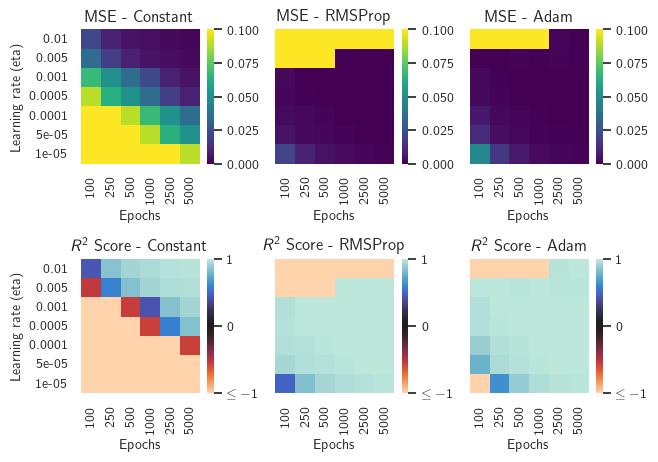

In [90]:
fig, axes = plt.subplots(2, 3, figsize=(tw, 12/2.54), sharey=True)
for i, scheduler in enumerate(schedulers_types):
    sns.heatmap(mse_matrices[i], ax=axes[0, i],
                xticklabels=epochs_range, 
                yticklabels=etas_range,
                cmap="viridis",
                vmin=0,
                vmax=0.10)
    axes[0, i].set_title(f"MSE - {scheduler}")
    axes[0, i].set_xlabel("Epochs")
    

    sns.heatmap(r2_matrices[i], ax=axes[1, i],
                xticklabels=epochs_range, 
                yticklabels=etas_range, 
                cmap="icefire_r",
                vmin=-1,
                vmax=1)
    axes[1, i].set_title(fr"$R^2$ Score - {scheduler}")
    axes[1, i].set_xlabel("Epochs")
    cbar = axes[1, i].collections[0].colorbar
    cbar.set_ticks([-1, 0, 1])
    tick_labels = [r"$\leq-1$", '0', '1']
    cbar.set_ticklabels(tick_labels)

axes[0, 0].set_ylabel("Learning rate (eta)")
axes[1, 0].set_ylabel("Learning rate (eta)")
plt.tight_layout()
saveplot("schedulers_mse_r2")

### Comparison with OLS, deg = 13

In [ ]:
lr = LinearRegression_own(intercept=True)
X_train_lr = lr.polynomial_features(x_train, 13)
X_test_lr = lr.polynomial_features(x_test, 13)
theta = lr.fit(X_train_lr, y_train)
predict_lr_test = lr.predict(X_test_lr, theta)
predict_lr_train = lr.predict(X_train_lr, theta)

nn_1l = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[50, 1],
    activation_types=['sigmoid', 'sigmoid'],
    cost_type='MSE'
)

nn_2l = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[100, 100, 1],
    activation_types=['sigmoid', 'sigmoid', 'sigmoid'],
    cost_type='MSE'
)

nn_1l._create_layers()
nn_2l._create_layers()

nn_1l._define_scheduler(type='Constant', eta=1e-3)
nn_2l._define_scheduler(type='Constant', eta=1e-3)

nn_1l._train(x_train, y_train, n_epochs=5000)
nn_2l._train(x_train, y_train, n_epochs=5000)

predict_l1_test = nn_1l._predict(x_test)
predict_l2_test = nn_2l._predict(x_test)
predict_l1_train = nn_1l._predict(x_train)
predict_l2_train = nn_2l._predict(x_train)

predicts_test = [predict_lr_test, predict_l1_test, predict_l2_test]
predicts_train = [predict_lr_train, predict_l1_train, predict_l2_train]
labels = ['Linear Regression (deg=13)', 'Neural Network (1L, 50N)', 'Neural Network (2L, 100N)']


In [ ]:
plt.figure(figsize=(12/2.54, 8/2.54))

palette = sns.color_palette("Paired")[1:4]

for i in range(len(predicts_test)):

    mse_test = mse(predicts_test[i], y_test)
    r2_test = r2_score(predicts_test[i], y_test)
    mse_train = mse(predicts_train[i], y_train)
    r2_train = r2_score(predicts_train[i], y_train)
    print(f"{labels[i]} => Test MSE: {mse_test:.3f}, Test R2: {r2_test:.3f} | Train MSE: {mse_train:.3f}, Train R2: {r2_train:.3f}")

    plt.scatter(x_test, predicts_test[i], marker='.', label=rf"{labels[i]}\n Test MSE = {mse_test:.3f}\n Test $R^2$ = {r2_test:.3f}", color=palette[i])
    plt.scatter(x_train, predicts_train[i], marker='.', color=palette[i])

plt.plot(x, y, c='k', alpha=0.6, label='True function')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Linear Regression (deg=13) => Test MSE: 0.141, Test R2: 0.985 | Train MSE: 0.168, Train R2: 0.992
Neural Network (1L, 50N) => Test MSE: 0.140, Test R2: -574.709 | Train MSE: 0.158, Train R2: -305.044
Neural Network (2L, 100N) => Test MSE: 0.004, Test R2: 0.948 | Train MSE: 0.003, Train R2: 0.958


Error in callback <function _draw_all_if_interactive at 0x0000021B65CF94E0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'Linear Regression (deg=13)\\\\n Test MSE = 0.141\\\\n Test R = 0.985'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpzu8g86ab 57f4ab8fc83af96235d1950110ad1b38.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(57f4ab8fc83af96235d1950110ad1b38.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-09-02>
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\sansmathfo
nts.sty
No file TS1xcmss.fd.
No file TS1cmsmf.fd.
)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.st
y)
==> First Aid for underscore.sty applied!

(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx.
sty) (C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvip
s.def)
No file 57f4ab8fc83af96235d1950110ad1b38.aux.

(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\omlcmssm.f
d)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\omscmsssy.
fd)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\omxcmssex.
fd)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\uxcmss.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\ot1xcmss.f
d)
! Undefined control sequence.
l.30 {\sffamily Linear Regression (deg=13)\n
                                             Test MSE = 0.141\n Test R = 0.9...

No pages of output.
Transcript written on C:\Users\Dell\.matplotlib\tex.cache\57\f4\tmpzu8g86ab\57f
4ab8fc83af96235d1950110ad1b38.log.




RuntimeError: latex was not able to process the following string:
b'Linear Regression (deg=13)\\\\n Test MSE = 0.141\\\\n Test R = 0.985'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp1n5ad8ux 57f4ab8fc83af96235d1950110ad1b38.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(57f4ab8fc83af96235d1950110ad1b38.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-09-02>
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\sansmathfo
nts.sty
No file TS1xcmss.fd.
No file TS1cmsmf.fd.
)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.st
y)
==> First Aid for underscore.sty applied!

(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx.
sty) (C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvip
s.def)
No file 57f4ab8fc83af96235d1950110ad1b38.aux.

(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\omlcmssm.f
d)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\omscmsssy.
fd)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\omxcmssex.
fd)
(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\uxcmss.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

(C:\Users\Dell\AppData\Local\Programs\MiKTeX\tex/latex/sansmathfonts\ot1xcmss.f
d)
! Undefined control sequence.
l.30 {\sffamily Linear Regression (deg=13)\n
                                             Test MSE = 0.141\n Test R = 0.9...

No pages of output.
Transcript written on C:\Users\Dell\.matplotlib\tex.cache\57\f4\tmp1n5ad8ux\57f
4ab8fc83af96235d1950110ad1b38.log.




<Figure size 472.441x314.961 with 1 Axes>

### Part c): Testing against other software libraries

You should test your results against a similar code using **Scikit-Learn** (see the examples in the above lecture notes from weeks 41 and 42) or **tensorflow/keras** or **Pytorch** (for Pytorch, see Raschka et al.'s text chapters 12 and 13). 

Furthermore, you should also test that your derivatives are correctly
calculated using automatic differentiation, using for example the
**Autograd** library or the **JAX** library. It is optional to implement
these libraries for the present project. In this project they serve as
useful tests of our derivatives.

Train R^2: -11.7022
Test R^2:  -12.9487


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


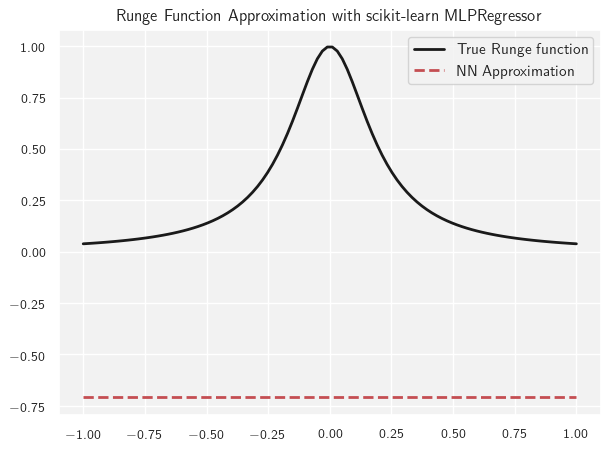

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# --- Create data ---
x = np.linspace(-1, 1, 100).reshape(-1, 1)
y = Runge(x, noise=False).ravel()  # flatten for scikit-learn

# --- Split data ---
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# --- Standardize inputs ---
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_scaled = scaler.transform(x)

# --- Define the neural network ---
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 100, 1),
    activation='relu',
    solver='adam',
    learning_rate_init=1e-4,
    max_iter=5000,
    random_state=42,
    tol=1e-8,
    verbose=False
)

# --- Train once ---
mlp.fit(x_train, y_train)

# --- Evaluate once ---
print(f"Train R^2: {mlp.score(x_train, y_train):.4f}")
print(f"Test R^2:  {mlp.score(x_test, y_test):.4f}")

# --- Predict and plot once ---
y_pred = mlp.predict(x_scaled)

plt.figure(figsize=(7, 5))
plt.plot(x, y, 'k-', label="True Runge function", lw=2)
plt.plot(x, y_pred, 'r--', label="NN Approximation", lw=2)
plt.title("Runge Function Approximation with scikit-learn MLPRegressor")
plt.legend()
plt.grid(True)
plt.show()


### Part d): Testing different activation functions and depths of the neural network

You should also test different activation functions for the hidden
layers. Try out the Sigmoid, the RELU and the Leaky RELU functions and
discuss your results.  Test your results as functions of the number of hidden layers and nodes. Do you see signs of overfitting?
It is optional in this project to perform a bias-variance trade-off analysis.

### Part e): Testing different norms

Finally, still using the one-dimensional Runge function, add now the
hyperparameters $\lambda$ with the $L_2$ and $L_1$ norms.  Find the
optimal results for the hyperparameters $\lambda$ and the learning
rates $\eta$ and neural network architecture and compare the $L_2$ results with Ridge regression from
project 1 and the $L_1$ results with the Lasso calculations of project 1.
Use again the same data sets and the best results from project 1 in your comparisons.

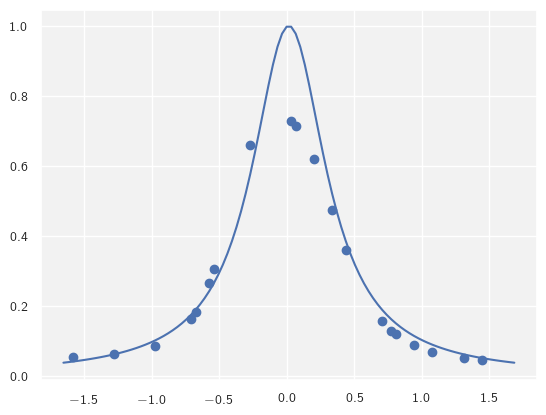

In [ ]:
nn_l1 = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[100, 100, 1],
    activation_funcs=[sigmoid, sigmoid, sigmoid],
    activation_ders=[sigmoid_der, sigmoid_der, sigmoid_der],
    cost_type='MSE',
    regression_method='Lasso',
    lbda1=0.001
)
nn_l1._reset_weights()
nn_l1._create_layers()
nn_l1._define_scheduler('Adam', eta=1e-3)   # best combo previously found
nn_l1._train(x_train, y_train)

nn_l1._predict(x_test)

plt.plot(x, y)
plt.scatter(x_test, nn_l1._predict(x_test), label="L1 Regularization")


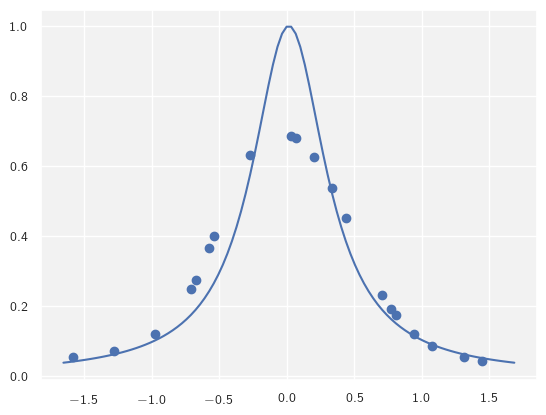

In [115]:
nn_l2 = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[100, 100, 1],
    activation_funcs=[sigmoid, sigmoid, sigmoid],
    activation_ders=[sigmoid_der, sigmoid_der, sigmoid_der],
    cost_type='MSE',
    regression_method='Ridge',
    lbda2=0.001
)
nn_l2._reset_weights()
nn_l2._create_layers()
nn_l2._define_scheduler('Adam', eta=1e-3)   # best combo previously found
nn_l2._train(x_train, y_train)

nn_l2._predict(x_test)

plt.plot(x, y)
plt.scatter(x_test, nn_l2._predict(x_test), label="L1 Regularization")

We now stick to Adam and find the relation eta/lambda for both L1 and L2 -- 4 matrices in total

In [120]:
mse_matrices_reg = list()
r2_martices_reg = list()

epochs = 500

lbda1_range = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
lbda2_range = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for reg_method, lbda_range in zip(['Lasso', 'Ridge'], [lbda1_range, lbda2_range]):
    mse_matrix_reg = np.zeros((len(lbda_range), len(etas_range)))
    r2_matrix_reg = np.zeros((len(lbda_range), len(etas_range)))

    for i, lbda in enumerate(lbda_range):
        for j, eta in enumerate(etas_range):
            if reg_method == 'Lasso':
                nn_reg = NeuralNetwork(
                    network_input_size=1,
                    layer_output_sizes=[100, 100, 1],
                    activation_funcs=[sigmoid, sigmoid, sigmoid],
                    activation_ders=[sigmoid_der, sigmoid_der, sigmoid_der],
                    cost_type='MSE',
                    regression_method='Lasso',
                    lbda1=lbda
                )
            else:
                nn_reg = NeuralNetwork(
                    network_input_size=1,
                    layer_output_sizes=[100, 100, 1],
                    activation_funcs=[sigmoid, sigmoid, sigmoid],
                    activation_ders=[sigmoid_der, sigmoid_der, sigmoid_der],
                    cost_type='MSE',
                    regression_method='Ridge',
                    lbda2=lbda
                )

            nn_reg._reset_weights()
            nn_reg._create_layers()
            nn_reg._define_scheduler('Adam', eta=eta)
            nn_reg._train(x_train, y_train, epochs)
            predict = nn_reg._predict(x_test)
            mse_val = mean_squared_error(predict, y_test)
            r2_val = r2_score(predict, y_test)

            mse_matrix_reg[i, j] = mse_val
            r2_matrix_reg[i, j] = r2_val
            print("Reg: {}, lbda = {}, eta = {} => MSE = {}, R2 = {}".format(reg_method, lbda, eta, mse_val, r2_val))
        
    mse_matrices_reg.append(mse_matrix_reg.copy())
    r2_martices_reg.append(r2_matrix_reg.copy())

Reg: Lasso, lbda = 1e-05, eta = 0.01 => MSE = 0.003985676934280557, R2 = 0.9495948104406572
Reg: Lasso, lbda = 1e-05, eta = 0.005 => MSE = 0.00045399416013100854, R2 = 0.9942545386506083
Reg: Lasso, lbda = 1e-05, eta = 0.001 => MSE = 0.0002679940865881756, R2 = 0.9967485187034637
Reg: Lasso, lbda = 1e-05, eta = 0.0005 => MSE = 0.00038750267943745987, R2 = 0.9951554872863274
Reg: Lasso, lbda = 1e-05, eta = 0.0001 => MSE = 0.0012590071183099275, R2 = 0.9833617975084288
Reg: Lasso, lbda = 1e-05, eta = 5e-05 => MSE = 0.0020603025410265248, R2 = 0.9720826486870151
Reg: Lasso, lbda = 1e-05, eta = 1e-05 => MSE = 0.006910627780105444, R2 = 0.888057563253145
Reg: Lasso, lbda = 0.0001, eta = 0.01 => MSE = 0.0025377272237773413, R2 = 0.9640774806832126
Reg: Lasso, lbda = 0.0001, eta = 0.005 => MSE = 0.0013911591434167874, R2 = 0.9828242957481953
Reg: Lasso, lbda = 0.0001, eta = 0.001 => MSE = 0.004078071133307432, R2 = 0.9475555134987199
Reg: Lasso, lbda = 0.0001, eta = 0.0005 => MSE = 0.00149131

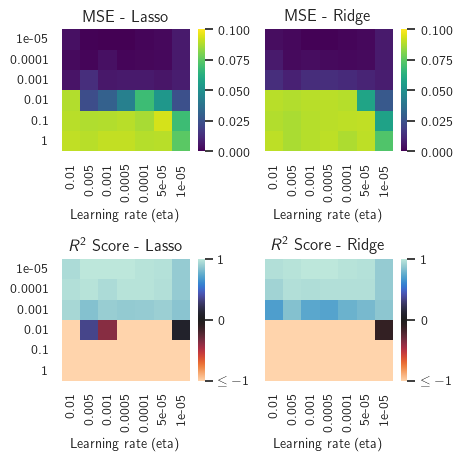

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(12/2.54, 12/2.54), sharey=True)
for i, reg_method in enumerate(['Lasso', 'Ridge']):
    sns.heatmap(mse_matrices_reg[i], ax=axes[0, i],
                xticklabels=etas_range, 
                yticklabels=lbda1_range if reg_method == 'Lasso' else lbda2_range,
                cmap="viridis",
                vmin=0,
                vmax=0.10)
    axes[0, i].set_title(f"MSE - {reg_method}")
    axes[0, i].set_xlabel("Learning rate (eta)")
    

    sns.heatmap(r2_martices_reg[i], ax=axes[1, i],
                xticklabels=etas_range, 
                yticklabels=lbda1_range if reg_method == 'Lasso' else lbda2_range, 
                cmap="icefire_r",
                vmin=-1,
                vmax=1)
    axes[1, i].set_title(fr"$R^2$ Score - {reg_method}")
    axes[1, i].set_xlabel("Learning rate (eta)")
    cbar = axes[1, i].collections[0].colorbar
    cbar.set_ticks([-1, 0, 1])
    tick_labels = [r"$\leq-1$", '0', '1']
    cbar.set_ticklabels(tick_labels)

    plt.tight_layout()

### Part f): Classification  analysis using neural networks

With a well-written code it should now be easy to change the
activation function for the output layer.

Here we will change the cost function for our neural network code
developed in parts b), d) and e) in order to perform a classification
analysis.  The classification problem we will study is the multiclass
MNIST problem, see the description of the full data set at
<https://www.kaggle.com/datasets/hojjatk/mnist-dataset>. We will use the Softmax cross entropy function discussed in a). 
The MNIST data set discussed in the lecture notes from week 42 is a downscaled variant of the full dataset. 

Feel free to suggest other data sets. If you find the classic MNIST data set somewhat limited, feel free to try the  
MNIST-Fashion data set at for example <https://www.kaggle.com/datasets/zalando-research/fashionmnist>.

To set up the data set, the following python programs may be useful

In [ ]:
from sklearn.datasets import fetch_openml

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

# Extract data (features) and target (labels)
X = mnist.data
y = mnist.target

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

You should consider scaling the data. The Pixel values in MNIST range from 0 to 255. Scaling them to a 0-1 range can improve the performance of some models. That is, you could implement the following scaling

In [127]:
X = X / 255.0

And then perform the standard train-test splitting

In [128]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

To measure the performance of our classification problem we will use the
so-called *accuracy* score.  The accuracy is as you would expect just
the number of correctly guessed targets $t_i$ divided by the total
number of targets, that is

$$
\text{Accuracy} = \frac{\sum_{i=1}^n I(t_i = y_i)}{n} ,
$$

where $I$ is the indicator function, $1$ if $t_i = y_i$ and $0$
otherwise if we have a binary classification problem. Here $t_i$
represents the target and $y_i$ the outputs of your FFNN code and $n$ is simply the number of targets $t_i$.

Discuss your results and give a critical analysis of the various parameters, including hyper-parameters like the learning rates and the regularization parameter $\lambda$, various activation functions, number of hidden layers and nodes and activation functions.  

Again, we strongly recommend that you compare your own neural Network
code for classification and pertinent results against a similar code using **Scikit-Learn**  or **tensorflow/keras** or **pytorch**.

If you have time, you can use the functionality of **scikit-learn** and compare your neural network results with those from Logistic regression. This is optional.
The weblink  here <https://medium.com/ai-in-plain-english/comparison-between-logistic-regression-and-neural-networks-in-classifying-digits-dc5e85cd93c3>compares logistic regression and FFNN using the so-called MNIST data set. You may find several useful hints and ideas from this article. Your neural network code can implement the equivalent of logistic regression by simply setting the number of hidden layers to zero and keeping just the input and the output layers. 

If you wish to compare with say Logisti Regression from **scikit-learn**, the following code uses the above data set

In [ ]:
from sklearn.linear_model import LogisticRegression
# Initialize the model
model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000, random_state=42)
# Train the model
model.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Part g) Critical evaluation of the various algorithms

After all these glorious calculations, you should now summarize the
various algorithms and come with a critical evaluation of their pros
and cons. Which algorithm works best for the regression case and which
is best for the classification case. These codes can also be part of
your final project 3, but now applied to other data sets.

## Summary of methods to implement and analyze

**Required Implementation:**
1. Reuse the regression code and results from project 1, these will act as a benchmark for seeing how suited a neural network is for this regression task.

2. Implement a neural network with

  * A flexible number of layers

  * A flexible number of nodes in each layer

  * A changeable activation function in each layer (Sigmoid, ReLU, LeakyReLU, as well as Linear and Softmax)

  * A changeable cost function, which will be set to MSE for regression and cross-entropy for multiple-classification

  * An optional L1 or L2 norm of the weights and biases in the cost function (only used for computing gradients, not interpretable metrics)

3. Implement the back-propagation algorithm to compute the gradient of your neural network

4. Reuse the implementation of Plain and Stochastic Gradient Descent from Project 1 (and adapt the code to work with the your neural network)

  * With no optimization algorithm

  * With RMS Prop

  * With ADAM

5. Implement scaling and train-test splitting of your data, preferably using sklearn

6. Implement and compute metrics like the MSE and Accuracy

### Required Analysis:

1. Briefly show and argue for the advantages and disadvantages of the methods from Project 1.

2. Explore and show the impact of changing the number of layers, nodes per layer, choice of activation function, and inclusion of L1 and L2 norms. Present only the most interesting results from this exploration. 2D Heatmaps will be good for this: Start with finding a well performing set of hyper-parameters, then change two at a time in a range that shows good and bad performance.

3. Show and argue for the advantages and disadvantages of using a neural network for regression on your data

4. Show and argue for the advantages and disadvantages of using a neural network for classification on your data

5. Show and argue for the advantages and disadvantages of the different gradient methods and learning rates when training the neural network

### Optional (Note that you should include at least two of these in the report):

1. Implement Logistic Regression as simple classification model case (equivalent to a Neural Network with just the output layer)

2. Compute the gradient of the neural network with autograd, to show that it gives the same result as your hand-written backpropagation.

3. Compare your results with results from using a machine-learning library like pytorch (https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

4. Use a more complex classification dataset instead, like the fashion MNIST (see <https://www.kaggle.com/datasets/zalando-research/fashionmnist>)

5. Use a more complex regression dataset instead, like the two-dimensional Runge function $f(x,y)=\left[(10x - 5)^2 + (10y - 5)^2 + 1 \right]^{-1}$, or even more complicated two-dimensional functions (see the supplementary material of <https://www.nature.com/articles/s41467-025-61362-4> for an extensive list of two-dimensional functions). 

6. Compute and interpret a confusion matrix of your best classification model (see <https://www.researchgate.net/figure/Confusion-matrix-of-MNIST-and-F-MNIST-embeddings_fig5_349758607>)

## Background literature

1. The text of Michael Nielsen is highly recommended, see Nielsen's book at <http://neuralnetworksanddeeplearning.com/>. It is an excellent read.

2. Goodfellow, Bengio and Courville, Deep Learning at <https://www.deeplearningbook.org/>. Here we recommend chapters 6, 7 and 8

3. Raschka et al. at <https://sebastianraschka.com/blog/2022/ml-pytorch-book.html>. Here we recommend chapters 11, 12 and 13.

## Introduction to numerical projects

Here follows a brief recipe and recommendation on how to write a report for each
project.

  * Give a short description of the nature of the problem and the eventual  numerical methods you have used.

  * Describe the algorithm you have used and/or developed. Here you may find it convenient to use pseudocoding. In many cases you can describe the algorithm in the program itself.

  * Include the source code of your program. Comment your program properly.

  * If possible, try to find analytic solutions, or known limits in order to test your program when developing the code.

  * Include your results either in figure form or in a table. Remember to        label your results. All tables and figures should have relevant captions        and labels on the axes.

  * Try to evaluate the reliabilty and numerical stability/precision of your results. If possible, include a qualitative and/or quantitative discussion of the numerical stability, eventual loss of precision etc.

  * Try to give an interpretation of you results in your answers to  the problems.

  * Critique: if possible include your comments and reflections about the  exercise, whether you felt you learnt something, ideas for improvements and  other thoughts you've made when solving the exercise. We wish to keep this course at the interactive level and your comments can help us improve it.

  * Try to establish a practice where you log your work at the  computerlab. You may find such a logbook very handy at later stages in your work, especially when you don't properly remember  what a previous test version  of your program did. Here you could also record  the time spent on solving the exercise, various algorithms you may have tested or other topics which you feel worthy of mentioning.

## Format for electronic delivery of report and programs

The preferred format for the report is a PDF file. You can also use DOC or postscript formats or as an ipython notebook file.  As programming language we prefer that you choose between C/C++, Fortran2008 or Python. The following prescription should be followed when preparing the report:

  * Use Canvas to hand in your projects, log in  at  <https://www.uio.no/english/services/it/education/canvas/> with your normal UiO username and password.

  * Upload **only** the report file or the link to your GitHub/GitLab or similar typo of  repos!  For the source code file(s) you have developed please provide us with your link to your GitHub/GitLab or similar  domain.  The report file should include all of your discussions and a list of the codes you have developed.  Do not include library files which are available at the course homepage, unless you have made specific changes to them.

  * In your GitHub/GitLab or similar repository, please include a folder which contains selected results. These can be in the form of output from your code for a selected set of runs and input parameters.

Finally, 
we encourage you to collaborate. Optimal working groups consist of 
2-3 students. You can then hand in a common report.